In [ ]:
import numpy as np
from numpy.linalg import solve
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy import optimize
from scipy.optimize import minimize_scalar
import egrss 
import lambda_fun
import os 

a,b = -0.2, 0.5
n = 100
p = 2
xi = (b-a) ** (2 * p - 1) 
x = np.linspace(a,b,N)
lamb = 1 / (0.2 ** 2)

def y(x):
        return 0.25*np.cos(4*np.pi *x) + 0.15*np.sin(12* np.pi *x) + 0.2 * x

yhat = y(x) + 1 / np.sqrt(lamb) * np.random.normal(loc = 0, scale = 1, size = x.shape)

def smoothing_spline_reg(y,Ut,Vt,Wt,eps,lamb,delt,perturb = None):
    # compute factorization
    d    =   delt / lamb
    Zt,c = egrss.potrf(Ut,Vt,d)
    
    # compute rhs
    if perturb is not None: 
        # perturbation of rhs
        n,  = y.shape
        xiy = np.random.normal(loc=0, scale=1, size= n)
        xix = np.random.normal(loc=0, scale=1, size= n)       
        rhs = egrss.symv(Utilde,Vtilde,y+ np.sqrt(lamb) / lamb * xiy) + np.sqrt(delt) / lamb * egrss.trmv(Utilde, Wtilde, xix, c = eps, trans = 'N')
        
    else:
        rhs = egrss.symv(Utilde,Vtilde,y)
        
    # solve LL'x = rhs    
    Ltrhs= egrss.trsv(Ut,Zt,rhs,c,'N')
    x    = egrss.trsv(Ut,Zt,Ltrhs,c,'T')
        
    return x

def plims(x,p = None):
    # computes the emperical quantiles of x
    # m is number of samples
    # n is number of parameters
    
    m,n = x.shape
    
    if p is None: 
        p = np.array([0.025, 0.975]) # corresponds to 95% CI
        
    k, = p.shape
    y = np.zeros((k,n))
    for i in range(n):
        y[:,i] = np.interp((m-1)*p,range(m),np.sort(x[:,i])) 
    
    return y

### Gibbs sampler - we aim to sample from the joint posterior pi(v,u,sigma,lambda,delta|y) 
# See posteriors derived in overleaf
import time
nsamps = 5000
K      = 2 # equvalent to degree of spline

alph   = 1e+3
# Initialization and memory allocation
lamb_samp   = np.zeros(nsamps)
delt_samp   = np.zeros(nsamps)
x_samp      = np.zeros((n,nsamps))


# pre-compute matrices and matrix-vector products
Ut, Vt = egrss.generators((x-a)/(b-a),K)

Utilde = Ut
Vtilde = Vt + alph * Ut
Wtilde,eps = egrss.potrf(Utilde,Vtilde,1e-10)

residual = yhat-x_samp[:,0]

for i in range(nsamps-1):      
    # sample hyperparameters lambda and nu (delta and alpha)
    # (1a) sample lambda    
    a0,b0    = 1.0 + n / 2, 1e-4 + 0.5 * np.dot(residual,residual)
    lamb_samp[i+1] =  np.random.gamma(shape=a0, scale=1/b0)

    # (1b) sample delta
    Linvx = egrss.trsv(Utilde,Wtilde,x_samp[:,i],eps,'N')
    a1,b1    = 1.0 + n / 2, (1e+4 + 0.5 * np.dot(Linvx,Linvx)) # 1e+4
    delt_samp[i+1] = np.random.gamma(shape=a1, scale=1/b1)

    # 2a) Compute posterior
    x_samp[:,i+1] = smoothing_spline_reg(yhat,Utilde,Vtilde,Wtilde,eps,lamb_samp[i+1],delt_samp[i+1],perturb = 1)
    
    residual = yhat-x_samp[:,i+1]

## Sample statistics 
# Remove burn-in phase 
burnin   = int(lamb_samp.size/ 2) 
x_res    = x_samp[:,burnin:]
lamb_res = lamb_samp[burnin:]
delt_res = delt_samp[burnin:]

# Reshape results for statistical functions 
delt_res.shape=(nsamps-burnin,1)
lamb_res.shape=(nsamps-burnin,1)

# Compute posterior mean 
lamb_mean = np.mean(lamb_res,0)
delt_mean = np.mean(delt_res,0)
x_mean    = np.mean(x_res,1)

# Compute 95% CI 
lamb_ci  = plims(lamb_res)
delt_ci  = plims(delt_res)
x_ci     = plims(x_res.T)

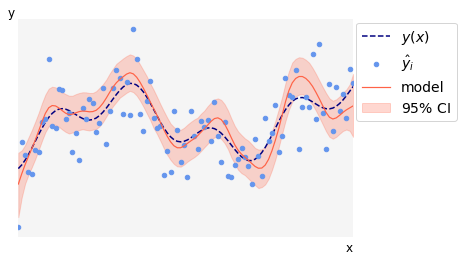

In [29]:
fig = plt.figure()
plt.plot(x,y(x),'--',color = 'navy', linewidth=1.5, label = '$y(x)$')
plt.plot(x,yhat,'bo',markersize = 4.5, color = 'cornflowerblue', label = '$\hat{y}_i$')
plt.plot(x,x_mean ,color = 'tomato', linewidth=1.2, label = 'model')
plt.fill_between(x,x_ci[0,:],x_ci[1,:], color='tomato', alpha=.25,label = '$95\%$ CI')
plt.xticks([])
plt.yticks([])
plt.xlabel('x', loc = 'right', fontsize = 12)
plt.ylabel('y', loc = 'top', rotation = 0, fontsize = 12)
plt.xlim([a,b])
plt.tick_params(left=True, bottom = False, right = False, top = False)
plt.legend(numpoints = 1, prop = {'size': 14}, loc = 'lower right',  bbox_to_anchor=(1.33, b))
ax = plt.gca()
ax.set_facecolor('whitesmoke')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()
my_path = os.getcwd()
fig.savefig(my_path + '/Plots/sim_sampling_fit.pdf', bbox_inches='tight')